<a href="https://colab.research.google.com/github/sasurasa/soda_ep1/blob/main/soda_1_survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

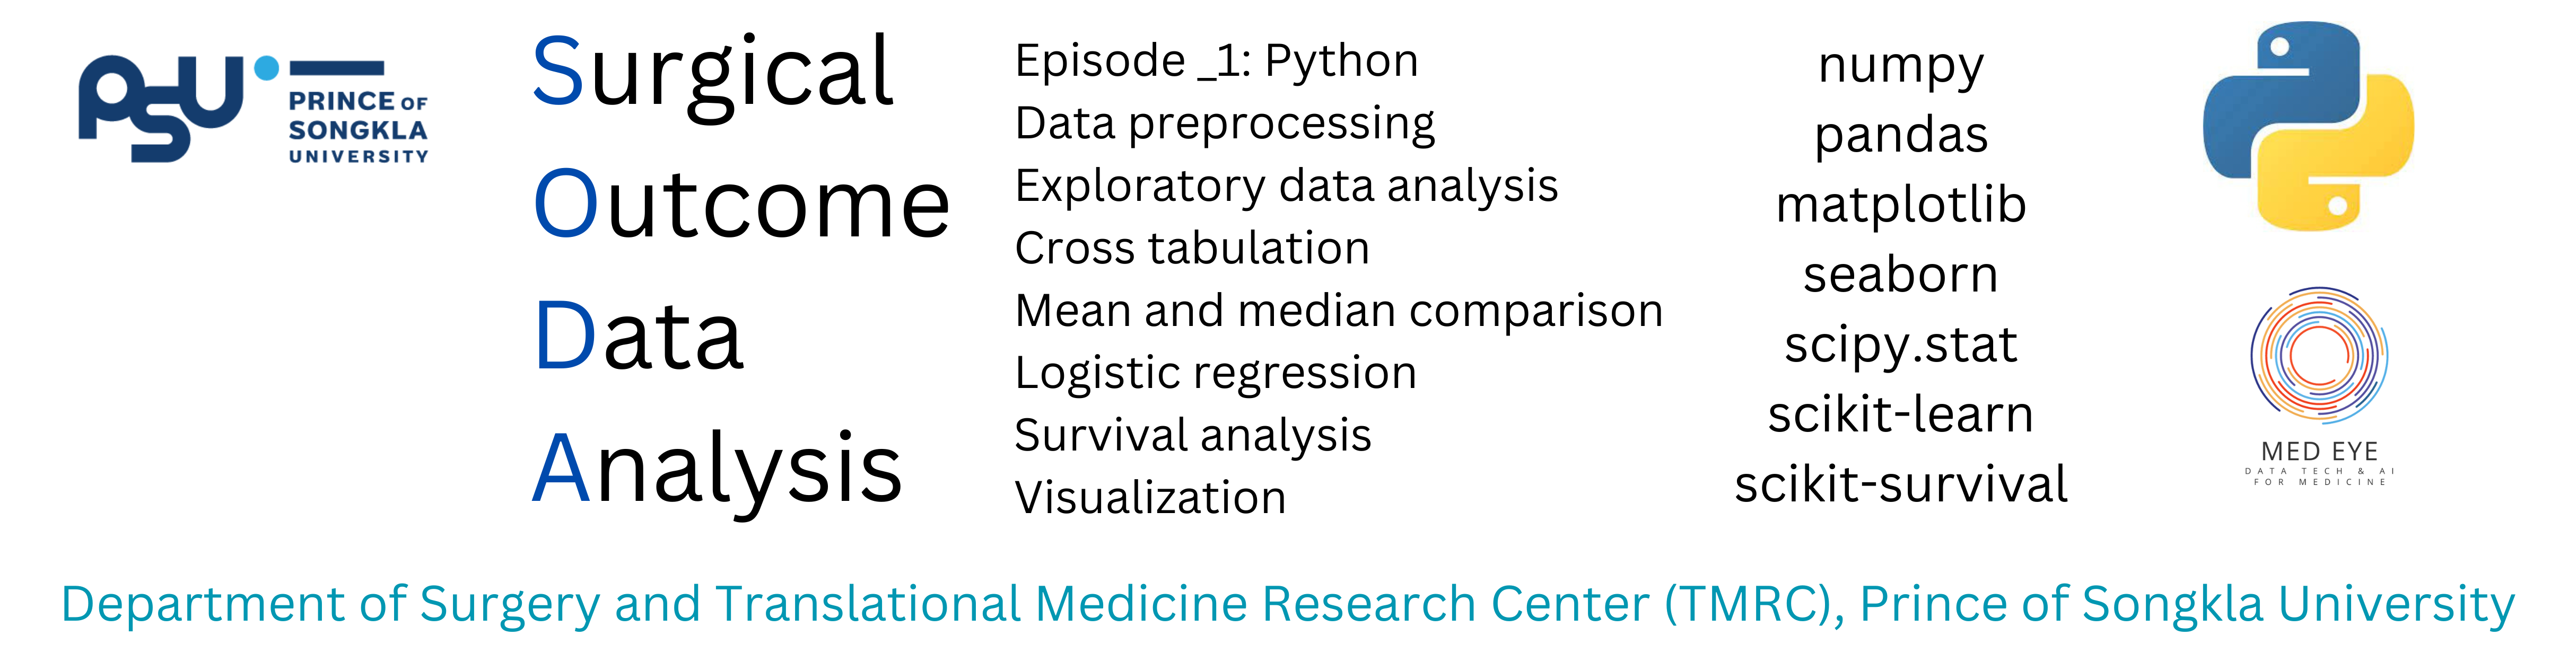

#Survival analysis
- Measuring and comparing time-to-event e.g. cancer survival, graft survival.
- Starting points (T0) can be: 'date of diagnosis', 'date of pathology report', date of surgery', etc. which should be the same if a comparison between groups is planned.
- Event date (TS) can be: the date when an event of interest occurs (event date) or the date when the patient was last evaluated or the date when the study ends (right-censor out). In cases of medical field, last follow-up date is preferably used rather than the end-of-study date for the right censoring, considering the accuracy of the event status.
- Interval (usually in days) is a function of TS - T0 (follow-up duration).
- An 'Event' defines the patient status at TS, which needs to be a boolean value (0/1); 0 for those who were censored out without the event, and 1 for those with the event.
- Examples of events are dead (overall survival), any of recurrence, a new metastasis, or progression of residual tumor (event-free survival), malfunction of a device (catheter survival), cholangitis (cholangitis-free survival), re-admission. Notice that the events in survival analysis need not be a real death.
- On the calculation of Kaplan-Meier survival analysis, the variable 'interval' and the 'event' are inputs.

In [ ]:
#Import necessary packages from Colab
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt


In [ ]:
#Install external packages and dependencies from PyPi
!pip install scikit-learn==1.4.0
!pip install scikit-survival
!pip install lifelines
from sksurv.nonparametric import kaplan_meier_estimator
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

Data used in this practice is a cancer bladder dataset modified from its original use in a study focusing on immunohistochemical subtyping and postoperative survival of patients.
[Bejrananda T.,et al. 2021](https://www.nature.com/articles/s41598-021-00628-5)


In [ ]:
#Import data file (Excel)
def soap_sheetin(path):
	data = pd.read_excel(path, sheet_name='Sheet1', parse_dates=True, engine='openpyxl')
	return data

In [ ]:
bladder = soap_sheetin('/content/psu_bladder_cancer.xlsx') #Bring in the excel database. Note that the path might need to be modified if the target Excel file is kept on other sites.
pd.set_option('display.max_columns', None)
bladder.head() #See the data structure

<ipython-input-36-f186f8557e0f>:3: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  data = pd.read_excel(path, sheet_name='Sheet1', parse_dates=True, engine='openpyxl')


,serial,age,sex,ecog,datedx,dateop,diversion,grade,t,n,m,ln,margin,lvi,cmt,cycle,lastdate,dead,gat3,ck20,ck56,ck14,gat31,ck201,ck561,ck141
0,1,74,1,1,2008-11-15,2009-01-22,1,1,3,1,0.0,1,0,1,0,0,2018-05-03,1,0,0,1,1,0,0,1,1
1,2,68,1,1,2008-09-01,2009-02-19,1,1,4,1,0.0,1,0,1,0,0,2009-09-03,1,1,0,0,0,1,0,0,0
2,3,51,2,1,2009-02-09,2009-04-02,1,1,4,0,0.0,0,0,0,0,0,2009-07-08,1,0,0,1,1,0,1,1,1
3,4,79,1,1,2008-12-23,2009-04-08,1,1,3,0,0.0,0,0,0,0,0,2009-04-11,1,1,1,0,0,1,1,0,0
4,5,72,1,1,2009-04-24,2009-06-25,1,1,3,0,0.0,0,0,0,0,0,2010-09-30,1,1,0,0,0,1,0,0,0


In [ ]:
bladder['interval'] = bladder['lastdate'] - bladder['datedx'] #Construct a new variable named 'interval'
bladder['interval'] = bladder['interval'].dt.days.astype('int16')
bladder.head()

,serial,age,sex,ecog,datedx,dateop,diversion,grade,t,n,m,ln,margin,lvi,cmt,cycle,lastdate,dead,gat3,ck20,ck56,ck14,gat31,ck201,ck561,ck141,interval
0,1,74,1,1,2008-11-15,2009-01-22,1,1,3,1,0.0,1,0,1,0,0,2018-05-03,1,0,0,1,1,0,0,1,1,3456
1,2,68,1,1,2008-09-01,2009-02-19,1,1,4,1,0.0,1,0,1,0,0,2009-09-03,1,1,0,0,0,1,0,0,0,367
2,3,51,2,1,2009-02-09,2009-04-02,1,1,4,0,0.0,0,0,0,0,0,2009-07-08,1,0,0,1,1,0,1,1,1,149
3,4,79,1,1,2008-12-23,2009-04-08,1,1,3,0,0.0,0,0,0,0,0,2009-04-11,1,1,1,0,0,1,1,0,0,109
4,5,72,1,1,2009-04-24,2009-06-25,1,1,3,0,0.0,0,0,0,0,0,2010-09-30,1,1,0,0,0,1,0,0,0,524


##One-group Kaplan Meier survival estimation

In [ ]:
def soap_single_kmc_(data, status, interval, max_time=None):
    sta = data[status].to_list()
    sta_bool = [bool(item) for item in sta]
    interv = data[interval]


    # If max_time is not provided, use the maximum value of interv
    if max_time is None:
        max_time = interv.max()

    kmf = KaplanMeierFitter()
    kmf.fit(durations=interv, event_observed=sta_bool)  # Fit the data into the model
    time, survival_prob = kmf.survival_function_.index, kmf.survival_function_["KM_estimate"]

    kmf.plot()
    plt.title('Kaplan-Meier Survival Curves')
    plt.ylabel("est. probability of survival")
    plt.xlabel("time $(days)$")

    plt.xlim(0, max_time)  # Use max_time to set the x-axis limit

    plt.show()


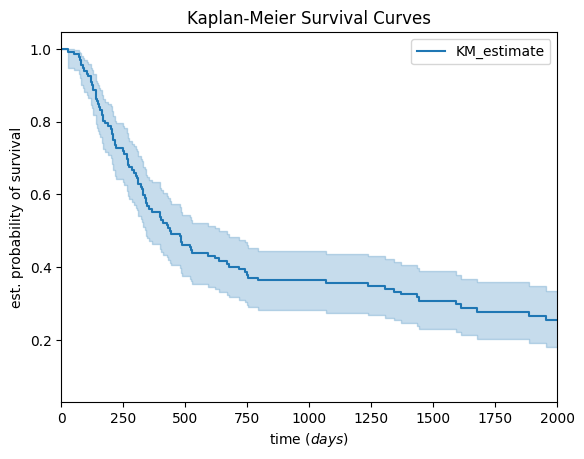

In [ ]:
soap_single_kmc_(bladder, 'dead', 'interval', 2000) #Display Kaplan-Meier curve of the whole dataset

In [ ]:
def soap_survival_ladder(data, status, interval): #Get time-point specific survival probability with the closest 95%CI
  kmf = KaplanMeierFitter()
  interval = data[interval]
  event = data[status]
  kmf.fit(interval, event_observed=event)
  time_points = [30, 365, 730, 1095, 1460, 1825]
  survival_prob = kmf.predict(time_points)
  kmf_times = kmf.survival_function_.index.to_numpy()

  closest_time_points = np.searchsorted(kmf_times, time_points, side='left')
  closest_time_points = np.minimum(closest_time_points, len(kmf_times) - 1)
  closest_kmf_times = kmf_times[closest_time_points]
  closest_confidence_intervals = kmf.confidence_interval_.loc[closest_kmf_times]
  closest_confidence_intervals.reset_index(inplace=True)
  closest_confidence_intervals.rename(columns={'index': 'Closest_days'}, inplace=True)

  survival_prob_df = survival_prob.to_frame(name='Survival Probability')
  survival_prob_df.reset_index(inplace=True)
  survival_prob_df.rename(columns={'index': 'Days'}, inplace=True)
  survival_prob_df['95%CI lower'] = closest_confidence_intervals['KM_estimate_lower_0.95']
  survival_prob_df['95%CI upper'] = closest_confidence_intervals['KM_estimate_upper_0.95']
  print(survival_prob_df)



In [ ]:
soap_survival_ladder(bladder, 'dead', 'interval')

   Days  Survival Probability  95%CI lower  95%CI upper
0    30              0.992424     0.940779     0.996189
1   365              0.560606     0.464222     0.633039
2   730              0.393939     0.303550     0.468342
3  1095              0.356061     0.268411     0.429596
4  1460              0.308398     0.231467     0.388415
5  1825              0.278198     0.191778     0.347057


#Two-group survival comparison

In [ ]:
#Exploring values in the target column
def soap_count_percent(df, col):
    abs_count = df[col].value_counts()
    rel_count = df[col].value_counts(normalize=True) * 100
    count_tab = pd.DataFrame({f'{col}_abs_count': abs_count, f'{col}_percent': rel_count})
    count_tab = count_tab.sort_index(ascending = True)
    count_tab.index.name = col
    print(count_tab)

In [ ]:
soap_count_percent(bladder, 'gat3')

      gat3_abs_count  gat3_percent
gat3                              
0                 31     23.484848
1                101     76.515152


In [ ]:
#Drawing a kpm graph with a comparison
def soap_multigroup_kp(data, event, interval, intervention):
    kmf = KaplanMeierFitter()
    groups = data[intervention].unique()
    for group in groups:
        data_gr = data[data[intervention] == group]
        kmf.fit(data_gr[interval], event_observed=data_gr[event], label=group)
        kmf.plot()
    plt.title('Kaplan-Meier Survival Curves')
    plt.xlabel('Time')
    plt.ylabel('Survival Probability')
    plt.legend(title=intervention)
    plt.show()

In [ ]:
soap_multigroup_kp(bladder, 'dead', 'interval', 'gat3' )

In [ ]:
def soap_logrank(data, event, interval, intervention):
    if data[intervention].nunique() != 2:
        print('As the factor', intervention, 'is non-binary, the Logrank statistics is not calculated.')
    else:
        interval_0 = []
        group_0 = data[data[intervention] == 0]
        for i in group_0[interval]:
            interval_0.append(i)
        T = interval_0

        interval_1 = []
        group_1 = data[data[intervention] == 1]
        for i in group_1[interval]:
            interval_1.append(i)
        T1 = interval_1

        censor_0 = []
        for j in group_0[event]:
            censor_0.append(j)
        E = censor_0

        censor_1 = []
        for k in group_1[event]:
            censor_1.append(k)
        E1 = censor_1
        results = logrank_test(T, T1, E, E1)
        if results.p_value >= 0.05:
            print('Log-rank for', intervention,' gives p-value at: %.5f' % results.p_value)
        else:
            print('Log-rank for', intervention,' gives p-value at: %.5f' % results.p_value, '**')

In [ ]:
soap_logrank(bladder, 'dead', 'interval', 'gat3')

Log-rank for gat3  gives p-value at: 0.00967 **


In [ ]:
#Batch log-rank test
def soap_batchlogrank(data, event, interval, batch):
    for i in batch:
        soap_logrank(data, event, interval, i)

In [ ]:
markers = ['gat3', 'ck20', 'ck56', 'ck14']
soap_batchlogrank(bladder, 'dead', 'interval', markers)

Log-rank for gat3  gives p-value at: 0.00967 **
Log-rank for ck20  gives p-value at: 0.28898
Log-rank for ck56  gives p-value at: 0.04785 **
Log-rank for ck14  gives p-value at: 0.47463


#Practice question
Do sex, ECOG score (ecog), margin, t stage (t), n stage (n), m stage (m), or lymphovascular invasion (lvi) have significant association with survival in bladder cancer in this series?

In [ ]:
#Cox's proportional hazard analysis

def soap_single_chr(data, event, interval, intervention):
    from lifelines import CoxPHFitter
    markers = []
    markers.append(intervention)
    markers.extend([interval, event])
    data = data[markers] #Feature selection

    cph = CoxPHFitter()
    cph.fit(data, duration_col= interval, event_col=event)
    summary = cph.summary
    summary_table = summary[['exp(coef)','exp(coef) lower 95%', 'exp(coef) upper 95%']]
    summary_table = summary_table.rename(columns={'exp(coef)': 'Hazard Ratio', 'exp(coef) lower 95%': '95%CI lower', 'exp(coef) upper 95%': '95%CI upper'}, errors="raise")

    print(summary_table)




In [ ]:
soap_single_chr(bladder, 'dead', 'interval', 'gat3')

           Hazard Ratio  95%CI lower  95%CI upper
covariate                                        
gat3           0.560531     0.359649     0.873618


In [ ]:
soap_single_chr(bladder, 'dead,' 'interval,' 't')# Notice that Cox's regression analysis can handle a non-binary independent variable.

           Hazard Ratio  95%CI lower  95%CI upper
covariate                                        
t              1.875247     1.528359     2.300867


In [ ]:
#Batch Cox's regression
def soap_batchcox(data, event, interval, batch):
    for i in batch:
        soap_single_chr(data, event, interval, i)

In [ ]:
soap_batchcox(bladder, 'dead', 'interval', markers)

           Hazard Ratio  95%CI lower  95%CI upper
covariate                                        
gat3           0.560531     0.359649     0.873618
           Hazard Ratio  95%CI lower  95%CI upper
covariate                                        
ck20           0.806322     0.541346     1.200997
           Hazard Ratio  95%CI lower  95%CI upper
covariate                                        
ck56           0.672932      0.45347     0.998604
           Hazard Ratio  95%CI lower  95%CI upper
covariate                                        
ck14           1.171731     0.757553     1.812353


In [ ]:
#Multivariable Cox's proportional hazard analysis
def soap_multi_chr(data, event, interval, intervention_list):
    from lifelines import CoxPHFitter
    markers = intervention_list
    markers.extend([interval, event])
    data = data[markers] #Feature selection

    cph = CoxPHFitter()
    cph.fit(data, duration_col= interval, event_col=event)
    summary = cph.summary
    summary_table = summary[['exp(coef)','exp(coef) lower 95%', 'exp(coef) upper 95%']]
    summary_table = summary_table.rename(columns={'exp(coef)': 'Hazard Ratio', 'exp(coef) lower 95%': '95%CI lower', 'exp(coef) upper 95%': '95%CI upper'}, errors="raise")

    print(summary_table)

In [ ]:
soap_multi_chr(bladder, 'dead', 'interval', markers)

           Hazard Ratio  95%CI lower  95%CI upper
covariate                                        
gat3           0.608437     0.368083     1.005739
ck20           0.884082     0.568095     1.375827
ck56           0.590590     0.381225     0.914937
ck14           1.260918     0.765821     2.076091
